### 导包+读入数据+预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'svg'  # 图片输出为矢量图，保证清晰度
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, f1_score, precision_score


In [2]:
data=pd.read_csv('./cancer-data.csv')
data=data.drop(['Unnamed: 0'],axis=1)
X=data.drop(['Group'],axis=1)
y=data['Group']

In [3]:
column=X.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(data=X,columns=column)

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=None)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (128, 202)
Test shape: (33, 202)


In [5]:
def crosspredict(estimator,Xtrain,ytrain,cv):
    print("cross-validate across the entire data set")
    y_pred_cross=cross_val_predict(estimator,Xtrain,ytrain,cv=cv)
    confusion_cross=confusion_matrix(ytrain,y_pred_cross)
    a=accuracy_score(ytrain,y_pred_cross)
    p=precision_score(ytrain, y_pred_cross)
    r=recall_score(ytrain, y_pred_cross)
    f1=f1_score(ytrain, y_pred_cross)
    wf1=f1_score(ytrain, y_pred_cross, average='weighted')
    #auc=roc_auc_score(ytrain,estimator.predict_proba(Xtrain)[:,1])
    print('the confusion_matrix of the model is : \n',confusion_cross)
    print('the accuracy of the model is : ',a)
    print("the precision score of the model is : ", p)
    print("the recall score of the model is :", r)
    print('the f1_score of the model  is :',f1)
    print('the weighted_f1 of the model is :',wf1)
    print('the classification_report is :\n',classification_report(ytrain, y_pred_cross,digits=4))
    #print('the auc is :',auc)
    return a,p,r,f1,wf1

In [6]:
#只在测试集上测试
def testpredict(estimator,Xtrain,ytrain,Xtest,ytest):
    print("只在测试集上测试")
    model=estimator.fit(Xtrain,ytrain)
    y_pred_train=model.predict(Xtrain)
    y_pred_test=model.predict(Xtest)
    confusion=confusion_matrix(ytest,y_pred_test)
    acc=accuracy_score(ytest, y_pred_test)
    rec=recall_score(ytest, y_pred_test)
    pre=precision_score(ytest, y_pred_test)
    f1=f1_score(ytest, y_pred_test)
    print('the confusion_matrix of the model is : \n',confusion)
    print('the accuracy of the model on testing set is ：',acc)
    print("the precision score of the model on testing set is : ",pre )
    print("the recall score of the model on testing set is :", rec)
    print('the f1_score of the model on testing set is :',f1)
    
    return acc,pre,rec,f1

In [7]:
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin, BaseEstimator
class MyEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model, mask) -> None:
        super().__init__()
        self.mask = mask
        self.model = model
    
    def fit(self, X, y=None):
        self.model.fit(X[self.mask],y)
        return self

    def predict(self, X):
        return self.model.predict(X[self.mask])
    
    def predict_proba(Xtrain):
        return self.model.predict_proba(Xtrain)[:,1]
        

In [8]:
# from itertools import *
# sel_seq_dt_mask=['APG_0101010010M','APG_0101010055P','APG_0101010063M','APG_0101010341M','APG_0101010354P']
# sel_seq_rf_mask=['APG_0101010055P','APG_0101010262P','APG_0101010266P']
# sel_seq_ada_mask=['APG_0101010033M','APG_0101010063M','APG_0101010067M','APG_0101010147M','APG_0101010192M', 'APG_0101010236M']
# sel_seq_gb_mask=['APG_0101010002M','APG_0101010055P','APG_0101010266P','APG_0101010354P']
# sel_seq_xgb_mask=['APG_0101010010M','APG_0101010037P','APG_0101010063M','APG_0101010078P','APG_0101010150P','APG_0101010230P','APG_0101010279P','APG_0101010312P','APG_0101020013M']
# sel_seq_gnb_mask=['APG_0101010010M','APG_0101010055P','APG_0101010057M','APG_0101010081M','APG_0101010085P','APG_0101010199P','APG_0101010264P','APG_0101010279P', 'APG_0101010300P']
# feature=list(set(sel_seq_dt_mask+sel_seq_rf_mask+sel_seq_ada_mask+sel_seq_gnb_mask+sel_seq_xgb_mask))
# model_dt_fs = MyEstimator(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=6), sel_seq_dt_mask)
# model_rf_fs = MyEstimator(RandomForestClassifier(max_depth=8, n_estimators=105, n_jobs=-1,random_state=90), sel_seq_rf_mask)
# model_ada_fs = MyEstimator(AdaBoostClassifier(learning_rate=0.1), sel_seq_ada_mask)
# model_gb_fs = MyEstimator(GradientBoostingClassifier(loss='exponential', n_estimators=300), sel_seq_gb_mask)
# model_xgb_fs = MyEstimator(XGBClassifier(booster='gblinear',learning_rate=0.3,n_estimators=10), mask=sel_seq_xgb_mask)
# model_gnb_fs=MyEstimator(GaussianNB(),mask=sel_seq_gnb_mask)
# from sklearn.ensemble import VotingClassifier
# model_voting= VotingClassifier([
#     ("dt",model_dt_fs),
#     ("rf",model_rf_fs),
#     ("ada", model_ada_fs),
#     #("gb",model_gb_fs),
#     ("xgb", model_xgb_fs),
#     ("gnb",model_gnb_fs),
# ], voting="hard")
# # a,b,c,d,e=crosspredict(model_voting,X,y,10)

In [9]:
from itertools import *
sel_seq_dt_mask=['Gender', 'APG_0101010027P', 'APG_0101010042M', 'APG_0101010049P','APG_0101010147M', 'APG_0101010199P', 'APG_0101010229P','APG_0101010275P', 'APG_0101010344M']
sel_seq_ada_mask=['APG_0101010033M','APG_0101010063M','APG_0101010067M','APG_0101010147M','APG_0101010192M', 'APG_0101010236M']
sel_seq_gb_mask=['APG_0101010010M', 'APG_0101010033M', 'APG_0101010092P','APG_0101010152M', 'APG_0101010179P', 'APG_0101010183P','APG_0101010257P', 'APG_0101010297P', 'APG_0101010322P']
sel_seq_xgb_mask=['APG_0101010010M','APG_0101010037P','APG_0101010063M','APG_0101010078P','APG_0101010150P','APG_0101010230P','APG_0101010279P','APG_0101010312P','APG_0101020013M']
sel_seq_SVC_mask=['APG_0101010002M', 'APG_0101010010M', 'APG_0101010029M','APG_0101010036M', 'APG_0101010071P', 'APG_0101010145P','APG_0101010152M', 'APG_0101010197P', 'APG_0101010235P','APG_0101010300P']

feature=list(set(sel_seq_dt_mask+sel_seq_SVC_mask+sel_seq_ada_mask+sel_seq_gb_mask+sel_seq_xgb_mask))
model_dt_fs = MyEstimator(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=6), sel_seq_dt_mask)
model_SVC_fs = MyEstimator(SVC(C=10, coef0=1, degree=3, kernel='poly', probability=True),mask=sel_seq_SVC_mask)
model_ada_fs = MyEstimator(AdaBoostClassifier(learning_rate=0.1), sel_seq_ada_mask)
model_gb_fs = MyEstimator(GradientBoostingClassifier(loss='exponential', n_estimators=300), sel_seq_gb_mask)
model_xgb_fs = MyEstimator(XGBClassifier(booster='gbtree',learning_rate=0.01,n_estimators=100,max_depth=5), mask=sel_seq_xgb_mask)
from sklearn.ensemble import VotingClassifier
model_voting = VotingClassifier([
    ("dt",model_dt_fs),
    ("SVC",model_SVC_fs),
    ("ada", model_ada_fs),
    ("gb",model_gb_fs),
    ("xgb", model_xgb_fs)
], voting="hard")
#a,b,c,d,e=crosspredict(model_voting,X,y,10)

## heatmap

In [10]:
fea=feature+['Group']

In [11]:
dataset=data[fea]

In [12]:
dataset

,APG_0101010300P,APG_0101010197P,APG_0101010344M,APG_0101010002M,APG_0101010010M,APG_0101010067M,APG_0101010183P,APG_0101010279P,Gender,APG_0101010257P,...,APG_0101010297P,APG_0101010322P,APG_0101010312P,APG_0101010071P,APG_0101010235P,APG_0101010229P,APG_0101010078P,APG_0101010147M,APG_0101010179P,Group
0,0.89,0.75,0.04,0.10,0.14,0.06,1.83,0.62,0,28.11,...,2.65,4.84,1.40,2.72,0.80,1.25,1.39,1.86,0.67,0
1,0.47,0.83,0.01,0.12,0.09,0.21,1.29,2.54,1,53.67,...,4.63,0.92,1.16,2.59,0.83,1.03,0.37,1.16,0.80,0
2,2.73,0.89,0.06,0.04,0.07,0.45,1.26,0.62,0,119.49,...,3.42,1.71,0.79,2.54,0.44,1.30,2.29,1.46,0.75,0
3,1.20,0.44,0.01,0.15,0.04,0.77,1.84,1.01,1,49.29,...,5.05,0.51,1.13,7.39,0.28,3.78,2.48,1.11,1.00,0
4,1.46,1.08,0.06,0.01,0.13,0.47,1.42,1.39,0,40.73,...,2.67,1.03,1.47,3.50,1.58,0.70,1.07,1.57,0.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,3.25,0.37,0.10,0.10,0.06,0.30,0.72,1.01,1,30.58,...,2.82,1.97,1.12,2.15,2.10,3.40,2.08,3.01,0.73,1
157,1.02,2.41,0.13,0.05,0.23,0.10,0.88,0.50,1,75.33,...,1.43,7.15,0.77,4.06,0.44,1.55,2.24,2.07,0.44,1
158,17.22,0.16,0.14,0.03,0.12,0.18,1.71,0.55,1,95.72,...,2.89,1.48,1.82,2.92,0.42,3.99,3.96,4.01,0.60,1
159,2.70,0.99,0.01,2.52,0.08,41.33,9.18,0.95,1,62.66,...,3.54,6.39,3.33,4.94,1.03,2.21,2.38,2.11,1.06,1


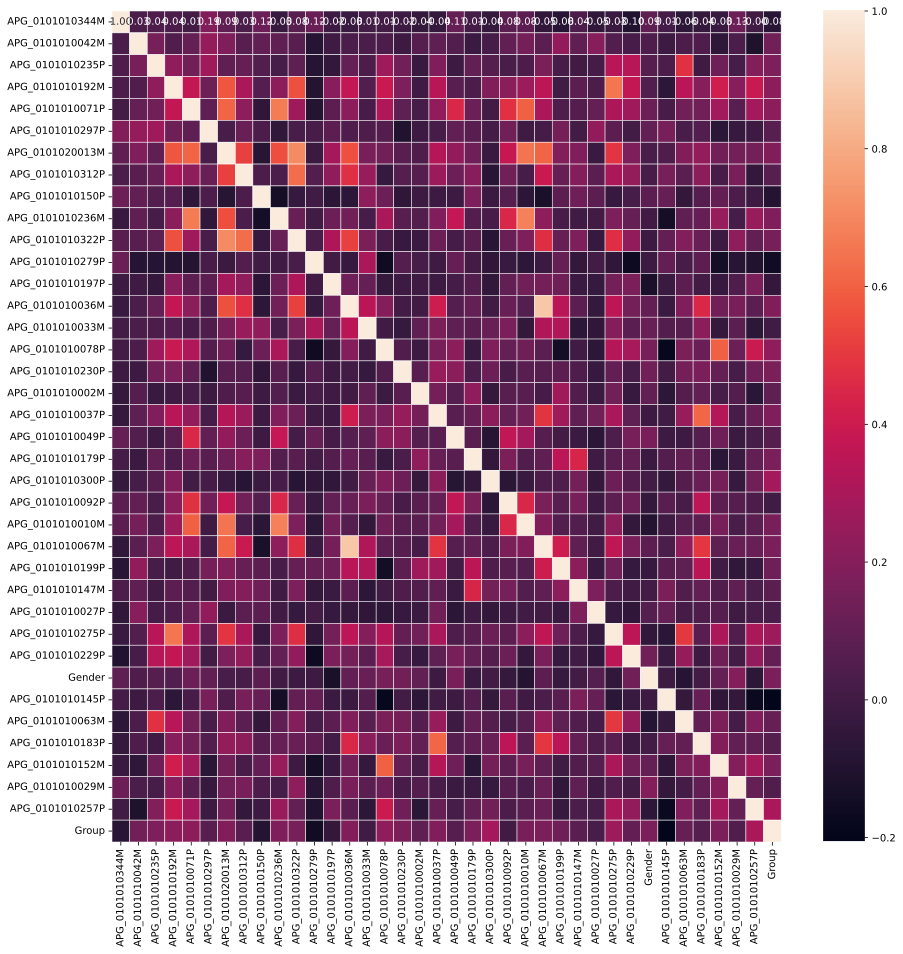

In [20]:
import seaborn as sns
corr_matrix=dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix,linewidths=0.5,annot=True,fmt=".2f",linecolor='white',yticklabels=True)
plt.savefig('C:/Users/睿/Desktop/ex1try/heatmap.png', dpi=500, bbox_inches='tight') 
plt.show()

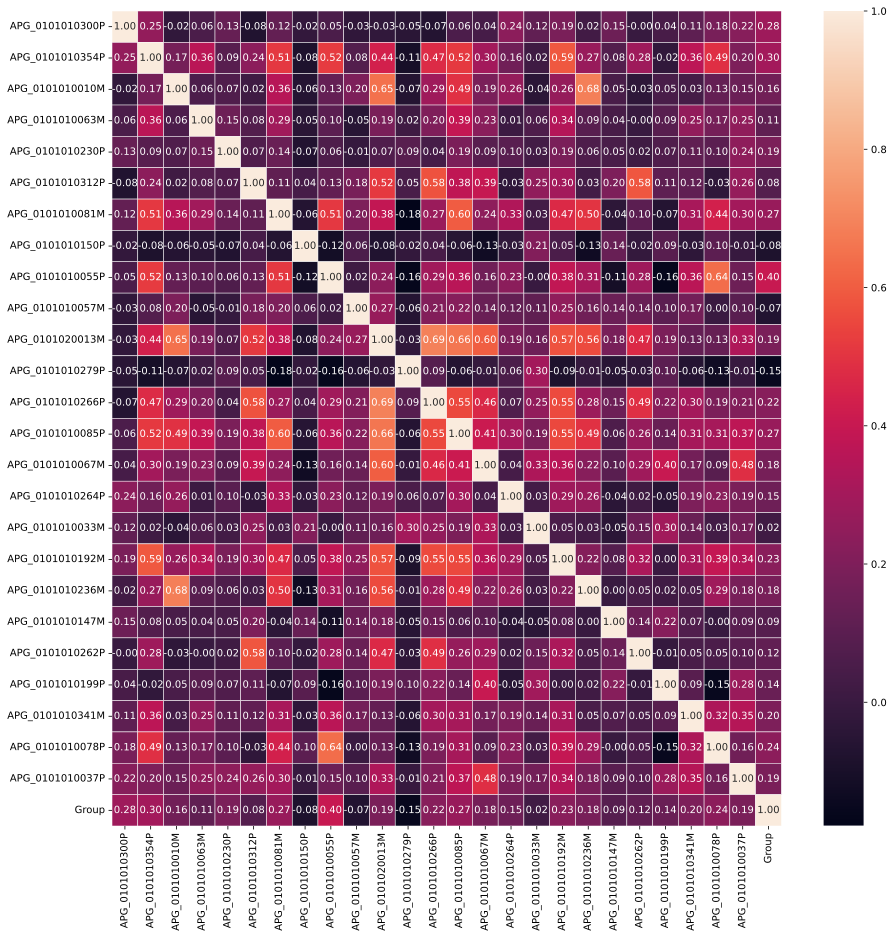

In [14]:
import seaborn as sns
corr_matrix=dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix,linewidths=0.5,annot=True,fmt=".2f",linecolor='white',yticklabels=True)
plt.savefig('C:/Users/睿/Desktop/ex1try/heatmap.png', dpi=500, bbox_inches='tight') 
plt.show()

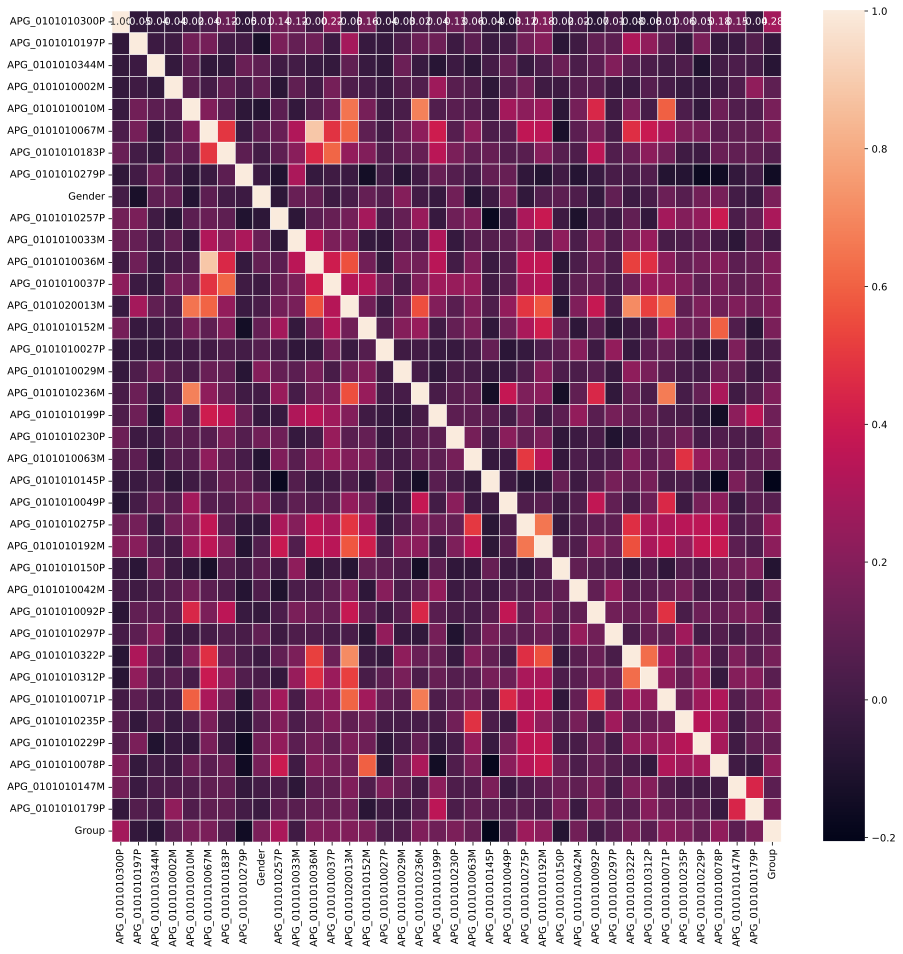

运行时间: 0.8120417594909668 秒


In [13]:
import seaborn as sns
import time

# 记录开始时间
start_time = time.time()

corr_matrix=dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix,linewidths=0.5,annot=True,fmt=".2f",linecolor='white',yticklabels=True)
plt.show()

# 记录结束时间
end_time = time.time()

# 计算并打印运行时间
print(f"运行时间: {end_time - start_time} 秒")
